In [ ]:
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os, datetime, time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Input 
from tensorflow.keras import callbacks, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,Adam, Adamax, Nadam,Ftrl
from keras.layers import Dense, Conv2D, LSTM, Attention, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization, MaxPooling2D, Dropout
from keras.layers import Reshape, UpSampling2D
from tensorflow.keras.metrics import Accuracy,Precision,Recall,AUC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation,RandomTranslation,Rescaling,RandomFlip,RandomContrast,Resizing

# models
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

path = './FER/'

# Data

In [ ]:
# load data
from pickle import load
data = load(open(path + '/data/fer2013_dict.pkl', 'rb'))

# unpack
x_train, y_train, x_val, y_val, x_test, y_test = data.values()

In [ ]:
# config data
batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
valid_steps_per_epoch = len(x_val) // batch_size

# augmentation config for training set (data already normalized, no need to 1/255)
train_datagen = image.ImageDataGenerator(rotation_range=0.3,
                                         horizontal_flip=True,
                                         shear_range=0.2,
                                         zoom_range=0.2)
std_datagen = image.ImageDataGenerator()

# pair
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = std_datagen.flow( x_val, y_val, batch_size=batch_size)
test_generator = std_datagen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
train_generator.next()[0].shape

(64, 48, 48, 1)

# Top Models

In [ ]:
# load models
from tensorflow.keras.models import load_model

# base
simpleCnn = load_model(path +'models/simpleCnn.h5') 

# pretrained
mob = load_model(path +'models/Pre_MobileNetV2.h5')  
inc = load_model(path +'models/Pre_Inception.h5')
xce = load_model(path +'models/Pre_Xception.h5')
vgg = load_model(path +'models/Pre_VGG19.h5')
res = load_model(path +'models/Pre_ResNet101V2.h5')

# ensembling
top_5 = load_model(path +'models/top5_model.h5')
top_6 = load_model(path +'models/top6c_model.h5')


# Model Comparasion

In [ ]:
# Evaluate on testset
mob_mx = mob.evaluate(test_generator)
inc_mx = inc.evaluate(test_generator)
con_mx = con.evaluate(test_generator)
xce_mx = xce.evaluate(test_generator)
vgg_mx = vgg.evaluate(test_generator)
res_mx = res.evaluate(test_generator)
cnn_mx = simpleCnn.evaluate(test_generator)
inc_mx = inc2.evaluate(test_generator)
top5_acc = top_5.evaluate(test_generator)[1]
top6_acc = top_6.evaluate(test_generator)[1]

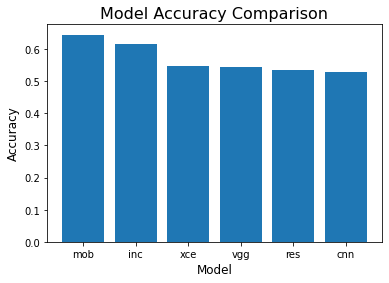

In [ ]:
models = [mob_mx, inc_mx, xce_mx, vgg_mx, res_mx, cnn_mx]
label = ['mob', 'inc', 'xce', 'vgg', 'res', 'cnn']

model_acc = []
for m in models:
  model_acc.append(m[1])

plt.bar(label, model_acc)
plt.title("Model Accuracy Comparison", 
          fontdict={'fontsize': 16})
plt.xlabel('Model', fontdict={'fontsize': 12})
plt.ylabel('Accuracy', fontdict={'fontsize': 12})
plt.show()

# Ensembling Evaluation

## Top 3

In [ ]:


# top models
simpleCnn = load_model(path +'models/simpleCnn.h5')

mob = load_model(path +'models/Pre_MobileNetV2.h5')  
inc = load_model(path +'models/features_InceptionV3.h5')
xce = load_model(path +'models/Pre_Xception.h5')
vgg = load_model(path +'models/Pre_VGG19.h5')
res = load_model(path +'models/ResNet101V2.h5')

INP_SIZE = (48,48)
NUM_CLASS = 7

lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

def top3(input_shape=(INP_SIZE[0],INP_SIZE[1],1), n_class=NUM_CLASS):    
    n_classes = n_class
    model_name = 'top3'

    inputs = keras.Input(shape=input_shape)
    y1 = mob(inputs)
    y2 = inc(inputs)
    y3 = xce(inputs)

    outputs = layers.average([y1, y2, y3]) 

    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)
    
    return model

top3().summary()
top3().evaluate(test_generator)

Model: "top3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 Pre_MobileNetV2 (Functional)   (None, 7)            3282381     ['input_10[0][0]']               
                                                                                                  
 features_InceptionV3 (Function  (None, 7)           21817133    ['input_10[0][0]']               
 al)                                                                                              
                                                                                                  
 Pre_Xception (Functional)      (None, 7)            69479       ['input_10[0][0]']            

[0.9228918552398682,
 0.6726666688919067,
 0.9298903942108154,
 0.7946110963821411,
 0.5210000276565552,
 35192.0,
 3126.0]

## top4

In [ ]:
INP_SIZE = (48,48)
NUM_CLASS = 7
# combile
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'categorical_crossentropy'
metrics = ['accuracy',
           tf.keras.metrics.AUC(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
          ]

def top4(input_shape=(INP_SIZE[0],INP_SIZE[1],1), n_class=NUM_CLASS):    
    n_classes = n_class
    model_name = 'top4'

    inputs = keras.Input(shape=input_shape)
    y1 = mob(inputs)
    y2 = inc(inputs)
    y3 = xce(inputs)
    y4 = simpleCnn(inputs)

    outputs = layers.average([y1, y2, y3, y4]) 
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)

    model.save(path + f'models/{model_name}.h5',overwrite=True)
    
    return model

top4().summary()
top4().evaluate(test_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "top4_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 Pre_MobileNetV2 (Functional)   (None, 7)            3282381     ['input_6[0][0]']                
                                                                                                  
 featureOnly_InceptionV3 (Funct  (None, 7)           21825325    ['input_6[0][0]']                
 ional)                                                                                           
                                                                                                  
 Pre_Xception (Functional)      (None, 7)            69479       ['input_6[0][0]']       

[1.2234755754470825,
 0.6073333621025085,
 0.9038545489311218,
 0.7239031791687012,
 0.47850000858306885,
 34905.0,
 2871.0]

## top5


In [ ]:
INP_SIZE = (48,48)
NUM_CLASS = 7
# combile
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'categorical_crossentropy'
metrics = ['accuracy',
           tf.keras.metrics.AUC(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
          ]

def top5(input_shape=(INP_SIZE[0],INP_SIZE[1],1), n_class=NUM_CLASS):    
    n_classes = n_class
    model_name = 'top5'

    inputs = keras.Input(shape=input_shape)
    y1 = mob(inputs)
    y2 = inc(inputs)
    y3 = xce(inputs)
    y4 = vgg(inputs)
    y5 = res(inputs)

    outputs = layers.average([y1, y2, y3, y4, y5]) 
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)

    model.save(path + f'models/{model_name}.h5',overwrite=True)
    
    return model

top5().summary()
top5().evaluate(test_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "top5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 Pre_MobileNetV2 (Functional)   (None, 7)            3282381     ['input_12[0][0]']               
                                                                                                  
 features_InceptionV3 (Function  (None, 7)           21817133    ['input_12[0][0]']               
 al)                                                                                              
                                                                                                  
 Pre_Xception (Functional)      (None, 7)            69479       ['input_12[0][0]']            

[0.9739557504653931,
 0.6641666889190674,
 0.9259108901023865,
 0.8308681845664978,
 0.43066665530204773,
 35474.0,
 2584.0]

# Model Training Details

## M0: simple CNN (54%)

Model: "fiveLayerCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 44, 44, 32)        832       
                                                                 
 batch_normalization_24 (Bat  (None, 44, 44, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 21, 21, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 18, 18, 32)        16416     
                                                                 
 batch_normalization_25 (Bat  (None, 18, 18, 32)      

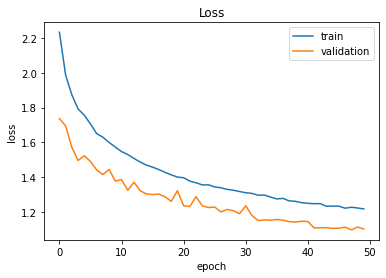

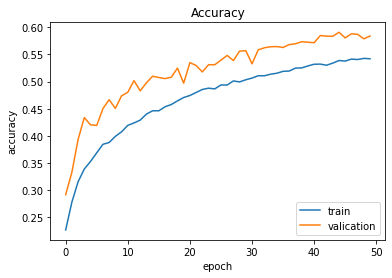

In [ ]:
# original input
IMG_H, IMG_W, IMG_C = (48, 48, 1)

NUM_CLASS = 7
lr = 0.0001
opt = Adam(learning_rate=lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
n_epochs = 50

def fiveLayerCNN(input_shape=(IMG_H,IMG_W,IMG_C), 
              num_class=NUM_CLASS):
  num_classes = num_class
  input_shape = input_shape
  model_name = 'fiveLayerCNN'

  inputs = keras.Input(shape = input_shape)
  x = Conv2D(32, 5, activation='elu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D(3, strides=2)(x)

  x = Conv2D(32, 4, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(3, strides=2)(x)

  x = Conv2D(64, 5, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(3, strides=2)(x)

  x = Flatten()(x)
  x = Dense(1024, activation='elu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(num_classes, activation='sigmoid')(x)
  
  # compile
  model = Model(inputs=inputs, outputs=outputs, name = model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  return model

fiveLayerCNN().summary()
run_all(fiveLayerCNN())

## M3:Xception (55%)

Model: "Pre_Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 org_img (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1050 (Conv2D)        (None, 44, 44, 32)        832       
                                                                 
 batch_normalization_1025 (B  (None, 44, 44, 32)       128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 22, 22, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1051 (Conv2D)        (None, 19, 19, 32)        16416     
                                                                 
 batch_normalization_1026 (B  (None, 19, 19, 32)      

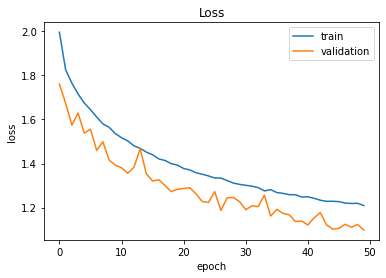

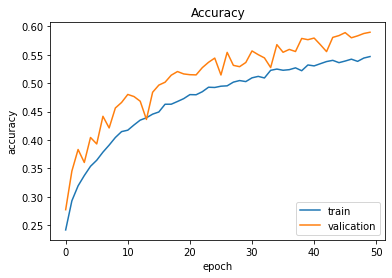

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

# original input
IMG_H, IMG_W, IMG_C = (48, 48, 1)
NUM_CLASS = 7

# config
lr = 0.0001
opt = Adam(learning_rate=lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
# train
n_epochs = 50

def Pre_Xception(input_shape=(IMG_W, IMG_H, IMG_C), n_class=NUM_CLASS):
  n_class = n_class
  model_name = 'Pre_Xception'

  m = keras.applications.VGG19(weights='imagenet', 
                                     input_shape=TGT_SIZE,
                                     include_top=False)

  inputs = keras.Input(shape=input_shape, name='org_img')
  x = img_augment(inputs)
  x = preprocess_input(x) #. scaling to (-1,1)
  x = m(x, training=False)

  x = Conv2D(32, kernel_size=5, activation='elu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(32, kernel_size=4, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(64, kernel_size=5, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(NUM_CLASS, activation="softmax")(x)

  # compile
  model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)

  return model

# run model
Pre_Xception().summary()
run_all(Pre_Xception())

## M4: ResNet101V2 (54%)

Model: "ResNet101V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 org_img (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1033 (Conv2D)        (None, 44, 44, 32)        832       
                                                                 
 batch_normalization_1009 (B  (None, 44, 44, 32)       128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 22, 22, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1034 (Conv2D)        (None, 19, 19, 32)        16416     
                                                                 
 batch_normalization_1010 (B  (None, 19, 19, 32)       

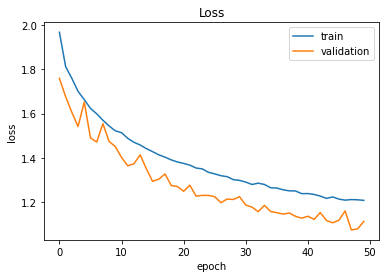

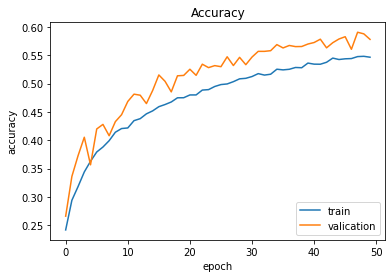

In [ ]:
from tensorflow.keras.applications import ResNet101V2

# original input
IMG_H, IMG_W, IMG_C = (48, 48, 1)
NUM_CLASS = 7

# config
lr = 0.0001
opt = Adam(learning_rate=lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
# train
n_epochs = 50

def ResNet101V2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=NUM_CLASS):
  n_class = n_class
  model_name = 'ResNet101V2'

  m = keras.applications.VGG19(weights='imagenet', 
                                     input_shape=TGT_SIZE,
                                     include_top=False)
  # m.trainable = False

  inputs = keras.Input(shape=input_shape, name='org_img')
  x = img_augment(inputs)
  x = m(x, training=False)

  x = Conv2D(32, kernel_size=5, activation='elu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(32, kernel_size=4, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(64, kernel_size=5, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(NUM_CLASS, activation="softmax")(x)

  # compile
  model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)

  return model

# run model
ResNet101V2().summary()
run_all(ResNet101V2())

## M5: VGG19 (54%)

Model: "Pre_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 org_img (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1006 (Conv2D)        (None, 44, 44, 32)        832       
                                                                 
 batch_normalization_1003 (B  (None, 44, 44, 32)       128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 22, 22, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1007 (Conv2D)        (None, 19, 19, 32)        16416     
                                                                 
 batch_normalization_1004 (B  (None, 19, 19, 32)       12

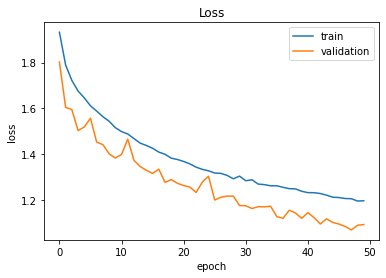

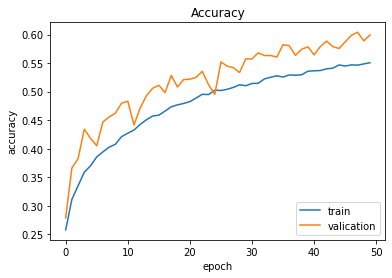

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

# original input
IMG_H, IMG_W, IMG_C = (48, 48, 1)
NUM_CLASS = 7

# config
lr = 0.0001
opt = Adam(learning_rate=lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
# train
n_epochs = 50

def Pre_VGG19(input_shape=(IMG_W, IMG_H, IMG_C), n_class=NUM_CLASS):
  n_class = n_class
  model_name = 'Pre_VGG19'

  m = keras.applications.VGG19(weights='imagenet', 
                                     input_shape=TGT_SIZE,
                                     include_top=False)
  
  inputs = keras.Input(shape=input_shape, name='org_img')
  x = img_augment(inputs)
  x = m(x, training=False)

  x = Conv2D(32, kernel_size=5, activation='elu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(32, kernel_size=4, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(64, kernel_size=5, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(NUM_CLASS, activation="softmax")(x)

  # compile
  model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)

  return model

# run model
Pre_VGG19().summary()
run_all(Pre_VGG19())

## M1: InceptionV3 (63%)

Model: "featureOnly_InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 org_img (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 img_augment (Sequential)    (None, 224, 224, 3)       6         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization_1420 (B  (None, 5, 5, 2048)       8192      
 atchNormalization)                                              
                                                                 
 max_pooling2d_163 (MaxPooli  (None, 2, 2, 2048)       0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_41  (None, 2048) 

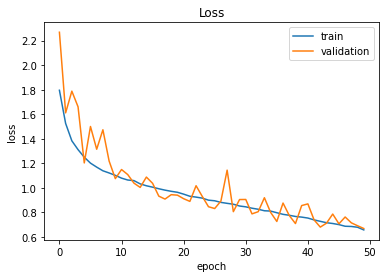

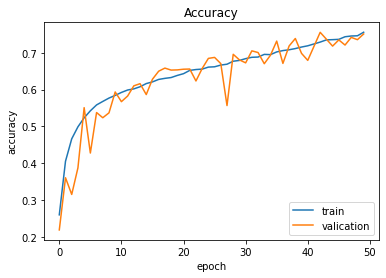

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

# original input
IMG_H, IMG_W, IMG_C = (48, 48, 1)
TGT_SIZE = (224,224,3)
NUM_CLASS = 7

# config
lr = 0.0001
opt = Adam(learning_rate=lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
# train
n_epochs = 50

def Pre_Inception(input_shape=(IMG_W, IMG_H, IMG_C), n_class=NUM_CLASS):
  n_class = n_class
  model_name = 'Pre_Inception'

  m = keras.applications.InceptionV3(weights='imagenet', 
                                     input_shape=TGT_SIZE,
                                     include_top=False)
  
  inputs = keras.Input(shape=input_shape, name='org_img')
  x = img_augment(inputs)
  x = m(x,training=False)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(NUM_CLASS, activation="softmax")(x)

  # compile
  model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)

  return model

# run model
Pre_Inception().summary()
run_all(Pre_Inception())

## M2: MobileNet (64%)

Model: "Pre_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 org_img (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 img_augment (Sequential)    (None, 224, 224, 3)       6         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1080 (Conv2D)        (None, 3, 3, 32)          1024032   
                                                                 
 batch_normalization_1039 (B  (None, 3, 3, 32)         128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 1, 1, 32)     

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


94/94 [==============================] - 5s 53ms/step - loss: 1.4970 - accuracy: 0.6447 - auc_35: 0.8951 - precision_35: 0.6637 - recall_35: 0.6317 - true_negatives_35: 34080.0000 - true_positives_35: 3790.0000


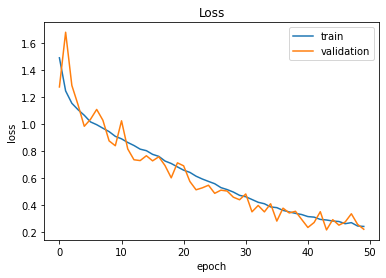

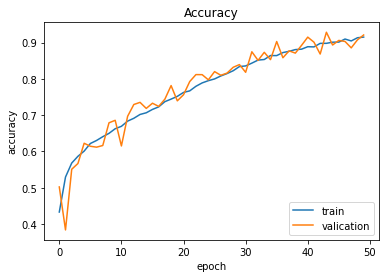

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# original input
IMG_H, IMG_W, IMG_C = (48, 48, 1)
TGT_SIZE = (224,224,3)
NUM_CLASS = 7

# config
lr = 0.0001
opt = Adam(learning_rate=lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
# train
n_epochs = 50

def Pre_MobileNetV2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=NUM_CLASS):
  n_class = n_class
  model_name = 'Pre_MobileNetV2'

  m = keras.applications.MobileNetV2(weights='imagenet', 
                                     input_shape=TGT_SIZE,
                                     include_top=False)

  inputs = keras.Input(shape=input_shape, name='org_img')
  x = img_augment(inputs)
  x = m(x,training=False)

  x = Conv2D(32, kernel_size=5, activation='elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(NUM_CLASS, activation="softmax")(x)

  # compile
  model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)

  return model

# run model
Pre_MobileNetV2().summary()
run_all(Pre_MobileNetV2())